# Representation Learning with SimCLR

In this exercise, we would like to implement the SimCLR model and train it on the FashionMNIST dataset. As described in the lecture the SimCLR model is used to learn representations with a contrastive loss.

![](figures/simclr_framework.png)

In [1]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms as T
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import random

In [2]:
# use this device on your laptop
device = 'cpu'
# uncomment below if you want to use a gpu (e.g. on Google Colab)
#device = 'cuda'

## Load Dataset
First, we will load the FashionMNIST dataset and display some of the samples.

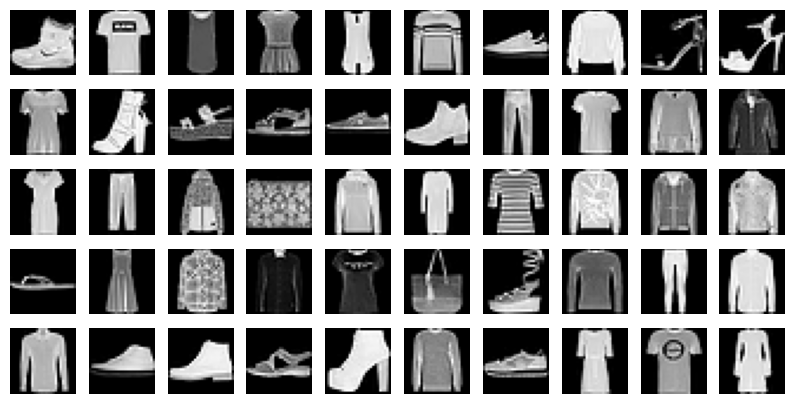

In [3]:
data_root = './data'
train_dataset = FashionMNIST(data_root, train=True, 
                             download=True, transform=T.ToTensor())
test_dataset = FashionMNIST(data_root, train=False, 
                            download=True, transform=T.ToTensor())

h, w = 5, 10
fig, ax = plt.subplots(h, w)
fig.set_size_inches((w, h))
ax = ax.ravel()
for i in range(h * w):
    img, label = train_dataset[i]
    ax[i].imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
    ax[i].axis('off')
plt.show()

## Model Architecture

We use a small convolutional network as an encoder and an MLP with 2 as non-linear projection head. The encoder transforms the 28x28x1 image into a 64-dimensional representation. The projection head encoder, projects the representation to a dimension of 32.

In [4]:
import torch.nn as nn

def conv_block(in_channels, out_channels, kernel=3, stride=1):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels=out_channels, 
                kernel_size=kernel, stride=stride),
      nn.BatchNorm2d(num_features=out_channels),
      nn.ReLU()
    )

## Creating the encoder
def create_encoder():
    encoder = nn.Sequential(conv_block(in_channels=1, out_channels=16),
                            nn.MaxPool2d(kernel_size=2),
                            conv_block(in_channels=16, out_channels=32),
                            nn.MaxPool2d(kernel_size=2),
                            conv_block(in_channels=32, out_channels=64),
                            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
    return encoder

## Creating the projection head
def create_projection_head():
    dim = 64
    proj_layers = []
    for _ in range(2):
        proj_layers.append(nn.Linear(dim, dim))
        proj_layers.append(nn.BatchNorm1d(dim))
        proj_layers.append(nn.ReLU(dim))
    projection_head = nn.Sequential(*proj_layers, nn.Linear(dim, 32))
    return projection_head

In [5]:
encoder = create_encoder()
projection_head = create_projection_head()

x = torch.zeros((1, 1, 28, 28))
encoder.eval()
projection_head.eval()
h = encoder(x)
print('h', h.shape)
z = projection_head(h)
print('z', z.shape)

h torch.Size([1, 64])
z torch.Size([1, 32])


## Task 1:  SimCLR Loss (30P)
Task: Given the embeddings from both of the views, implement the SimCLR loss function.
\begin{aligned}
\mathcal{L} = -\frac{1}{N} \sum_{i, j \in MB} \log\frac{\exp\left(\text{sim}\left(\mathbf{z}_{i}, \mathbf{z}_{j}\right)/\tau\right)}{\sum^{2N}_{k=1} 1_{[k\neq{i}]}\exp\left(\text{sim}\left(\mathbf{z}_{i}, \mathbf{z}_{k}\right)/\tau\right)}
\end{aligned}

where $z_i$, $z_j$ are hidden representations of two augmented views of the same example; $\text{sim}(u, v) = \frac{u^T v}{\lVert u \rVert \lVert v \rVert}$ is the cosine similarity between two vectors. $\tau$ is a temperature scalar and MB is a randomly sampled mini-batch consisting of augmented pairs of images. 

In [6]:
def simclr_loss(z1, z2, temperature=0.1):
    # z1 contains the first view for all examples and z2 the second view
    # this means that z1[i] and z2[i] correspond to the same original image
    # N = z1.shape[0]
    # use tau/temperature = 0.1

    N = z1.shape[0]

    loss_a = -(1/N) * torch.sum(torch.cosine_similarity(z1, z2, dim=1) / temperature) * 2

    loss_d = torch.cat((z1, z2))
    loss_d = loss_d / torch.linalg.vector_norm(loss_d, dim=1, keepdim=True)

    loss_d = torch.matmul(loss_d, loss_d.T)

    loss_d = loss_d / temperature

    loss_d = torch.exp(loss_d)

    loss_d = loss_d * (~torch.eye(2*N, dtype=torch.bool)).type(torch.int)

    loss_d = torch.sum(loss_d, dim=0)

    loss_d = torch.log(loss_d)

    loss_d = torch.sum(loss_d) / N

    loss = loss_a + loss_d

    return loss

In [7]:
# let's compute the simclr loss for random embeddings 
# and for embeddings where the two views have exactly the same embedding
# Our loss should be in this range during the optimization process
# here you can test if your computation is efficient and gives the right loss range
# The computation should take less than a second for the batch size below

torch.manual_seed(0)
z1 = torch.rand(size=(1024, 32)) - 0.5
z2 = torch.rand(size=(1024, 32)) - 0.5

random_loss = simclr_loss(z1, z2).item()
print('random loss', random_loss)

loss = simclr_loss(z1, z1).item()
print('views matching exactly', loss)

# Note that the values here are double as high as in the provided pdf for the exercise.
# This is because the solution used the pytorch CrossEntropy module, which normalizes by 
# 2N, and not N as shown in the function above. Both would be correct.

random loss 18.447248458862305
views matching exactly 0.6981754302978516


## Augmentations
Given an image x, we want to create two views $x_1$ and $x_2$ which are created by augmenting the image $x$. The following torchvision augmentation does a random horizontal flip of the image and does a random resized crop. As the image is grayscale in this example, we do not do any color jitter augmentation.

In [8]:
augment = T.Compose([T.RandomResizedCrop(28, scale=(0.1, 1.0), 
                     interpolation=T.InterpolationMode('bicubic')),
                     T.RandomHorizontalFlip(),
                     T.ToTensor(),
                     T.Normalize((0.5,), (0.5,))
                     ])

## Task 2: Generate Two views (10P)
Implement the view generating torchvision transform below. Given a batch of images $x$, we want to generate two augmented versions of the image (views). Use the augment function to augment the image.

In [9]:
class ViewTransform(object):
    
    # TODO implement this __call__ function to create 
    # two views from the image x and return them as tuple
    def __call__(self, x):
        x1 = augment(x)
        x2 = augment(x)
        return x1, x2
    
train_dataset.transform = ViewTransform()

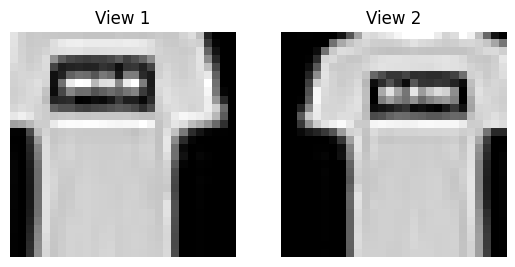

In [10]:
# We show two views of the same image below, here you can test your implementation.
torch.manual_seed(0)
random.seed(0)

(x1, x2), y = train_dataset[1]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(x1[0], cmap='gray')
ax[0].set_title('View 1')
ax[0].axis('off')
ax[1].imshow(x2[0], cmap='gray')
ax[1].set_title('View 2')
ax[1].axis('off')
plt.show()

## Training Loop
The following method contains the SimCLR training code. We use the data loader which generates two views for each image, pass the views through the encoder and the projection head and then compute the SimCLR loss.

In [13]:
import torch.optim
import torch.nn
from tqdm.auto import tqdm
import os
import numpy as np

def train(loader, epochs=5):
    torch.manual_seed(0)
    random.seed(0)
    
    encoder = create_encoder()
    projection_head = create_projection_head()
    model = torch.nn.Sequential(encoder, projection_head)
    model = model.to(device)
    model.train()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.3, 
                                momentum=0.9, weight_decay=0.0001, 
                                nesterov=True)
    i = 0
    for k in range(epochs):
        losses = []
        for (x1, x2), _ in tqdm(loader):
            optimizer.zero_grad()

            x1 = x1.to(device)
            x2 = x2.to(device)

            z1 = model(x1)
            z2 = model(x2)
            loss = simclr_loss(z1, z2)
            loss.backward()
            optimizer.step()

            i += 1
            losses.append(loss.detach().item())

        print(f'epoch: {k}, loss: {np.mean(losses)}')

        # save model after each epoch
        os.makedirs('models', exist_ok=True)
        torch.save(encoder.state_dict(), f'models/model_{k}.pt')

    return encoder

## Run Training
Run the training loop for 5 epochs. This should take around 5 minutes on a cpu. We use a large batch size of 1024.

In [14]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
encoder = train(train_loader)

100%|██████████| 59/59 [00:28<00:00,  2.09it/s]


epoch: 0, loss: 11.39548131975077


100%|██████████| 59/59 [00:27<00:00,  2.12it/s]


epoch: 1, loss: 9.691136117708885


100%|██████████| 59/59 [00:27<00:00,  2.16it/s]


epoch: 2, loss: 9.041265115899554


100%|██████████| 59/59 [00:27<00:00,  2.15it/s]


epoch: 3, loss: 8.538238056635452


100%|██████████| 59/59 [00:27<00:00,  2.15it/s]

epoch: 4, loss: 8.201621346554514


In [15]:
transform = T.Compose([T.ToTensor(), T.Normalize((0.5,), (0.5,))])
train_eval = FashionMNIST(data_root, train=True, 
                         download=True, transform=transform)
test_eval = FashionMNIST(data_root, train=False,
                         download=True, transform=transform)

#

# Task 3: Linear Probing (20P)
Now we want to test how good the encoder maps the images into semantically meaningful representations. Therefore, we compute the embeddings and then fit a linear classifier on top of the representations. Given the data loader and encoder, implement a method that extracts the embeddings/representations and corresponding labels. Run the linear classifer after this to check the quality of the embeddings. We evaluate the encoder after the first and last epoch.

In [35]:
def compute_embeddings(dataset, encoder):
    dl = DataLoader(dataset, batch_size=32)
    X = []
    Y = []

    for x, y in dl:
        X.append(encoder(x))
        Y.append(y)
    
    X = torch.cat(X).cpu().detach().numpy()
    Y = torch.cat(Y).cpu().detach().numpy()
    
    return X, Y

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
for k in [0, 4]:
    encoder = create_encoder()
    encoder.load_state_dict(torch.load(f'models/model_{k}.pt', weights_only=True))
    encoder.eval()

    xtrain, ytrain = compute_embeddings(train_eval, encoder)
    xtest, ytest = compute_embeddings(test_eval, encoder)

    clf = LogisticRegression(random_state=0, max_iter=1000, C=0.3)
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xtest)
    acc = accuracy_score(ytest, ypred)
    print(f"Accuracy: {acc}")

Accuracy: 0.7329
Accuracy: 0.7798


We see that the linear probing accuracy improves during training. The numbers do not have to match exactly to the ones provided in the pdf. We just want to see that the representation quality improves over the training time. Further training and a model with more capacity further increases the accuracy.